<a href="https://colab.research.google.com/github/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/blob/main/drl_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning Applied to Algorithmic Trading

<a href="https://www.kaggle.com/addarm/unsupervised-learning-as-signals-for-pairs-trading" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

INTRO


This deep learning network was inspired by the paper:
```BibTeX
@article{theate2021application,
  title={An application of deep reinforcement learning to algorithmic trading},
  author={Th{\'e}ate, Thibaut and Ernst, Damien},
  journal={Expert Systems with Applications},
  volume={173},
  pages={114632},
  year={2021},
  publisher={Elsevier}
}
```

In [14]:
try:
  import google.colab

  !sudo apt-get update
  !sudo apt-get install -y xvfb ffmpeg freeglut3-dev
  !pip install 'imageio==2.4.0'
  !pip install pyvirtualdisplay
  !pip install tf-agents[reverb]
  !pip install pyglet
  !pip install tf-keras

  IN_COLAB = True
except:
  IN_COLAB = False

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already th

In [15]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # KERAS 2 only for tfagents
import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'
if IN_COLAB or IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle or Collab...')
    %pip install scikit-learn
    %pip install tensorflow
    %pip install tqdm
    %pip install matplotlib
    %pip install python-dotenv
    %pip install yfinance
    %pip install pyarrow
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_DIR = "/kaggle/input/DATASET"
else:
    DATA_DIR = "./data/"
    print('Running Local...')

import numpy as np
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from datetime import datetime
from pandas.tseries.offsets import BDay

from scipy.stats import skew, kurtosis

import tensorflow as tf
from tf_agents.environments import py_environment, utils
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import tf_py_environment
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.metrics import tf_metrics
from tf_agents.eval import metric_utils
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy

import reverb
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

os.getcwd()

Running in Kaggle or Collab...


'/content'

In [16]:
START_DATE = "2017-01-01"
SPLIT_DATE = '2018-1-1' # Turning point from train to tst
END_DATE = "2019-12-31" # pd.Timestamp(datetime.now() - BDay(1)).strftime('%Y-%m-%d')
DATA_DIR = "./data"
INDEX = "Date"
TARGET = 'TSLA'
TICKER_SYMBOLS = [TARGET]
INTERVAL = "1d"

MODELS_PATH = './models'
LOGS_PATH = './logs'

ACT_LONG = 2
ACT_HOLD = 1
ACT_SHORT = 0

CAPITAL = 100
FEES = 0.1 / 100

FEATURES = ["Close", "High", "Low", "Open", "Volume"]
STATE_LEN = 1
OBS_SPACE = (STATE_LEN)*len(FEATURES)
ACT_SPACE = 2

BATCH_SIZE = 64 # OBS_SPACE * 100
LEARN_RATE = 1e-3
TOTAL_ITERS = 10 # 10000
EPISODES = 10
INIT_COLLECT = 10 # 100
TOTAL_COLLECT = 1
LOG_INTERVALS = 1 # 200
TEST_INTERVALS = 2 # 1000
MEMORY_LENGTH = OBS_SPACE * 100

# Financial Data

In [17]:
def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=INTERVAL, datadir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_parquet(cached_file_path)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=INTERVAL,
                )
                assert len(df) > 0
                df.to_parquet(cached_file_path, index=True, compression="snappy")
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(TICKER_SYMBOLS)
tickers[TARGET]

TSLA => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.56, skewness:-0.28, outliers_count:0,  nan_count: 0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500
2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500
2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500
2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500
2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500
...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500


# Trading Environment

In [18]:
class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - stateLength: Number of past observations to consider for the state.
    - transactionCosts: Costs associated with trading actions.
    """

    def __init__(self, data, features, money, stateLength, transactionCosts):
        super(TradingEnv, self).__init__()
        # self.data = self.preprocess_data(data)
        self.data = data
        self.features = features
        self.data_dim = len(self.features)
        self.min_balance = -money//4
        self.initial_balance = money
        self.state_length = stateLength
        self.transaction_cost = transactionCosts
        self._episode_ended = False

        self._batch_size = 1
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.data_dim,), dtype=np.float32, name='observation')

        self.reset()

    @property
    def batched(self):
        return False #True

    @property
    def batch_size(self):
        return None #self._batch_size

    @batch_size.setter
    def batch_size(self, size):
        self._batch_size = size

    def preprocess_data(self, df):
        log_returns = np.log(df / df.shift(1))
        normalized_data = (log_returns - log_returns.mean()) / log_returns.std()
        normalized_data.dropna(inplace=True)
        return normalized_data

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.position = 0
        self.total_shares = 0
        self.current_step = self.state_length
        self._episode_ended = False
        initial_observation = self._next_observation()
        return ts.restart(initial_observation)

    def _next_observation(self):
        """Generates the next observation based on the current step."""
        obs = self.data[self.features].iloc[self.current_step-self.state_length:self.current_step]
        obs = obs.values[0]
        obs = obs.flatten().astype(np.float32)
        return obs

    def _step(self, action):
        """Executes a trading action and returns the new state of the environment."""
        if self._episode_ended:
            return self.reset()

        current_price = self.data.iloc[self.current_step]['Close']
        self.current_step += 1
        reward = 0

        if action == ACT_SHORT or action == ACT_LONG:
            if self.total_shares > 0:
                self.balance += self.total_shares * current_price * (1 - self.transaction_cost)
                reward = self.balance - self.initial_balance
                self.total_shares = 0
            if action == ACT_LONG:
                self.position = 1
                self.total_shares = self.balance // (current_price * (1 + self.transaction_cost))
                self.balance -= self.total_shares * current_price * (1 + self.transaction_cost)
            elif action == ACT_SHORT:
                self.position = -1

        if self.balance < self.min_balance:
            # bankrupt
            done = True
            reward = -1
        else:
            done = self.current_step >= len(self.data)
        reward = np.clip(reward, -1, 1)
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward)

    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Balance: {self.balance}')

stock= tickers[TARGET]
train_data = stock[stock.index < pd.to_datetime(SPLIT_DATE)].copy()
test_data = stock[stock.index >= pd.to_datetime(SPLIT_DATE)].copy()

train_env = TradingEnv(train_data, FEATURES, CAPITAL, STATE_LEN, FEES)
utils.validate_py_environment(train_env, episodes=EPISODES)
test_env = TradingEnv(test_data, FEATURES, CAPITAL, STATE_LEN, FEES)
utils.validate_py_environment(train_env, episodes=EPISODES//4)

print(f"TimeStep Specs: {train_env.time_step_spec()}")
print(f"Action Specs: {train_env.action_spec()}")
print(f"Reward Specs: {train_env.time_step_spec().reward}")

time_step = train_env.reset()
print(f'Time step: {time_step}')
action = np.array(ACT_HOLD, dtype=np.int32)
next_time_step = train_env.step(action)
print(f'Next time step: {next_time_step}')

TimeStep Specs: TimeStep(
{'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(5,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)})
Action Specs: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=2)
Reward Specs: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Time step: TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([1.4466000e+01, 1.4688667e+01, 1.4064000e+01, 1.4324000e+01,
       8.8849504e+07], dtype=float32)})
Next time step: TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float

# Deep Q-Network Architecure

## Architecture

2 models:
- Policy Model: This is the primary model that the agent uses to make decisions or select actions based on the current state of the environment. The policy model is actively trained and updated throughout the training process based on the agent's experiences. In real-life applications, after the training phase is complete, the policy model is what gets deployed to make decisions or take actions in the given environment.
- Target Model: The target model is used exclusively during the training phase to provide a stable target for the temporal difference (TD) error calculation, which is crucial for the stability of the Q-learning updates. The target model's weights are periodically synchronized with the policy model's weights but at a much slower rate. This delayed update helps to stabilize the learning process by making the target for the policy updates more consistent across training batches. The target model itself is not used for decision-making or action selection outside of the training context.

Some notes on this 2 model arch:
- Stability/Reducing Temporal Correlations: The agent learns a policy that maps states to actions by using a Q-function. This Q-function estimates the rewards by taking a certain action in a given state. The learning process continuously updates the Q-values based on new experiences. If the Q-function is constantly changing—as it would be when updates are made based on estimates from the same function—it can lead to unstable training dynamics. The estimates can become overly optimistic, and the learning process can diverge.
- Target: The target network is a stable baseline for the policy network to compare against. While the policy network is frequently updated to reflect the latest learning, the target network's weights are updated less frequently. This slower update rate provides a fixed target for the policy network to aim for over multiple iterations, making the learning process more stable.

In practice, the policy network is responsible for selecting actions during training and gameplay. Its weights are regularly updated to reflect the agent's learning. The target network, on the other hand, is used to generate the Q-value targets for the updates of the policy network. Every few steps, the weights from the policy network are copied to the target network, ensuring the target for the updates remains relatively stable but still gradually adapts to the improved policy. The policy model is used both during training (for learning and decision-making) and after training (for decision-making in the deployment environment).

The target model is used during the training process only, to calculate stable target values for updating the policy model.
After training is complete and the model is deployed in a real-world application, only the policy model is used to make decisions or take actions based on the learned policy. The target model's role ends with the completion of the training phase, as its primary purpose is to aid in the convergence and stability of the training process itself.

## DRL Flow

- Initialization: init policy network and the target network with the same architecture but separate parameters.
- Data Preparation: Normalize input data using calculated coefficients to ensure consistency in scale.
- Learning Process:
    -At each training step, observe the current market state and process it through normalization.
    - Select an action using the epsilon-greedy policy (a balance between exploration and exploitation) based on the current state.
    - Execute the selected action in the simulated trading environment, observe the next state, and receive a reward based on the action's outcome.
    - Store the experience (current state, action, reward, next state) in the replay memory.
    - Sample a random batch of past experiences from the replay memory for learning to reduce correlation between consecutive learning steps.
    - Use the policy network to predict Q-values for the current states and the target network to calculate the target Q-values for the next states.
    - Update the policy network by minimizing the difference between its Q-value predictions and the target Q-values using backpropagation.
    - Every few steps, update the target network's parameters with the policy network's parameters to gradually adapt the learning target.
- Evaluation and Adjustment: Periodically test the trained policy network on a separate validation set or environment to evaluate performance.
    -Repeat the learning and evaluation process for many episodes until the policy network stabilizes and performs satisfactorily.
- Application Phase
    - Model Deployment: Deploy the trained policy network in a real-world environment or a simulation that closely mimics real trading conditions.
    - Real-time Operation: Observe the current market state and process it (normalization, etc.) as done during training.
    - Use the trained policy network to select the action that maximizes expected rewards based on the current market state, leaning towards exploitation of the learned policy over exploration. Execute the selected action in the market (buy, sell, hold).
- Continuous Learning:
    - Repeat the learning process with new market data and experiences, possibly in a less frequent, offline manner.
    - Update the policy and target networks as new data becomes available and as the market evolves to maintain or improve performance over time.

In [19]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

def create_q_network(env, fc_layer_params = (100, 50)):
    env = tf_py_environment.TFPyEnvironment(env)

    action_tensor_spec = tensor_spec.from_spec(env.action_spec())
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    def _dense_layer(num_units):
        return tf.keras.layers.Dense(
            num_units,
            activation=tf.keras.activations.relu,
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=2.0, mode='fan_in', distribution='truncated_normal'))

    dense_layers = [_dense_layer(num_units) for num_units in fc_layer_params]
    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-0.03, maxval=0.03),
        bias_initializer=tf.keras.initializers.Constant(-0.2))
    q_net = sequential.Sequential(dense_layers + [q_values_layer])

    return q_net

def create_agent(q_net, env, optimizer = tf.keras.optimizers.Adam(learning_rate=LEARN_RATE)):
    env = tf_py_environment.TFPyEnvironment(env)

    train_step_counter = tf.Variable(0)
    agent = dqn_agent.DqnAgent(
        env.time_step_spec(),
        env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        epsilon_greedy = 1.,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

    agent.initialize()
    print(agent.policy)
    print(agent.collect_policy)
    return agent

q_net = create_q_network(train_env)
agent = create_agent(q_net, train_env)

Num GPUs Available:  0


# Trading Operations

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(5,), dtype=tf.float32, name='observation', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32)),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})
('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')
TimeStep(
{'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'discount': <tf.Tensor: shape

Training Loop:   0%|          | 0/10 [00:00<?, ?it/s]WARNING:tensorflow:From /usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: calling foldr_v2 (from tensorflow.python.ops.functional_ops) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
Training Loop:  10%|█         | 1/10 [00:02<00:19,  2.18s/it]

step = 1: loss = 20876026183680.0
step = 2: loss = 5131141644288.0


Training Loop:  20%|██        | 2/10 [00:13<01:00,  7.59s/it]

step = 2: Average Return = 0.0
step = 3: loss = 2030732312576.0
step = 4: loss = 3346116116480.0


Training Loop:  40%|████      | 4/10 [00:24<00:38,  6.37s/it]

step = 4: Average Return = 0.0
step = 5: loss = 3900519219200.0
step = 6: loss = 2406473793536.0


Training Loop:  60%|██████    | 6/10 [00:36<00:24,  6.03s/it]

step = 6: Average Return = 0.0
step = 7: loss = 2390858924032.0
step = 8: loss = 3822194524160.0


Training Loop:  80%|████████  | 8/10 [00:47<00:11,  5.88s/it]

step = 8: Average Return = 0.0
step = 9: loss = 5216951861248.0
step = 10: loss = 11412348862464.0


Training Loop: 100%|██████████| 10/10 [00:58<00:00,  5.89s/it]

step = 10: Average Return = 0.0

Training completed. Mean Reward: -3322.6895, Mean Loss: 11412348862464.0000


'./models/dqn_trained.h5-1'

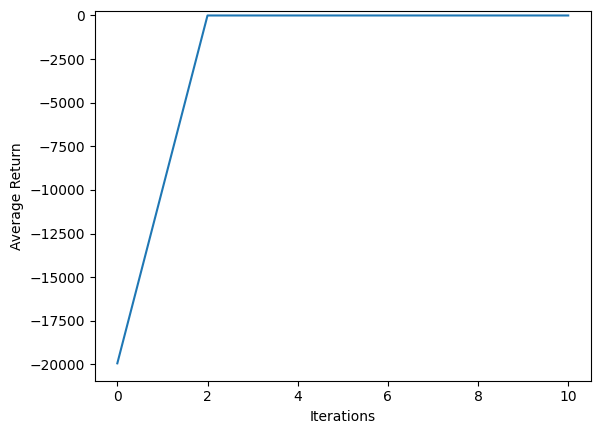

In [20]:
class TradingSimulator:
    def __init__(self, env, eval_env, agent, episodes=EPISODES, batch_size=BATCH_SIZE, num_eval_episodes=TEST_INTERVALS, collect_steps_per_iteration=INIT_COLLECT, replay_buffer_max_length=MEMORY_LENGTH , num_iterations = TOTAL_ITERS, log_interval=LOG_INTERVALS, eval_interval=TEST_INTERVALS):
        self.py_env = env
        self.env =  tf_py_environment.TFPyEnvironment(self.py_env)
        self.py_eval_env = eval_env
        self.eval_env =  tf_py_environment.TFPyEnvironment(self.py_eval_env)
        self.agent = agent
        self.episodes = episodes
        self.log_interval = log_interval
        self.eval_interval = eval_interval

        self.batch_size = batch_size
        self.num_eval_episodes = num_eval_episodes
        self.collect_steps_per_iteration = collect_steps_per_iteration
        self.replay_buffer_max_length = replay_buffer_max_length
        self.num_iterations = num_iterations

        self.policy = self.agent.policy
        self.collect_policy = self.agent.collect_policy
        self.random_policy = random_tf_policy.RandomTFPolicy(
            self.env.time_step_spec(),
            self.env.action_spec())

        self.replay_buffer_signature = tensor_spec.from_spec(
            self.agent.collect_data_spec)
        self.replay_buffer_signature = tensor_spec.add_outer_dim(
            self.replay_buffer_signature)

    def compute_avg_return(self, environment, policy, num_eval_episodes):
        total_return = 0.0
        for _ in range(num_eval_episodes):
            time_step = self.env.reset()
            episode_return = 0.0

            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = environment.step(action_step.action)
                episode_return += time_step.reward
                total_return += episode_return

        avg_return = total_return / self.episodes
        return avg_return.numpy()[0]

    def init_memory(self, table_name = 'uniform_table'):
        self.table = reverb.Table(
            table_name,
            max_size=self.replay_buffer_max_length,
            sampler=reverb.selectors.Uniform(),
            remover=reverb.selectors.Fifo(),
            rate_limiter=reverb.rate_limiters.MinSize(1),
            signature=self.replay_buffer_signature)

        self.reverb_server = reverb.Server([self.table])
        self.replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
                                    self.agent.collect_data_spec,
                                    table_name=table_name,
                                    sequence_length=2,
                                    local_server=self.reverb_server)

        self.rb_observer = reverb_utils.ReverbAddTrajectoryObserver(self.replay_buffer.py_client, table_name, sequence_length=2)

        print(self.agent.collect_data_spec)
        print(self.agent.collect_data_spec._fields)

        # Random collections to init and test
        py_driver.PyDriver(
            self.py_env,
            py_tf_eager_policy.PyTFEagerPolicy(self.random_policy, True),
            [self.rb_observer],
            max_steps=self.collect_steps_per_iteration).run(self.py_env.reset())

        time_step = self.env.reset()
        print(time_step)
        print(self.random_policy.action(time_step))

        self.compute_avg_return(self.eval_env, self.random_policy, self.num_eval_episodes)

        self.dataset = self.replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=self.batch_size, num_steps=2).prefetch(3)

        iterator = iter(self.dataset)
        print(iterator)

        return self.dataset, iterator

    def train(self):
        _, iterator = self.init_memory()

        self.agent.train = common.function(self.agent.train)
        self.agent.train_step_counter.assign(0)

        # Agent's first eval
        avg_return = self.compute_avg_return(self.eval_env, self.agent.policy, self.num_eval_episodes)
        returns = [avg_return]
        time_step = self.py_env.reset()
        collect_driver = py_driver.PyDriver(
            self.py_env,
            py_tf_eager_policy.PyTFEagerPolicy(self.agent.collect_policy, use_tf_function=True),
            [self.rb_observer],
            max_steps=self.collect_steps_per_iteration)

        for _ in tqdm(range(self.num_iterations), desc="Training Loop"):
            time_step, _ = collect_driver.run(time_step)
            experience, _ = next(iterator)
            train_loss = self.agent.train(experience).loss

            step = self.agent.train_step_counter.numpy()

            if step % self.log_interval == 0:
                print('step = {0}: loss = {1}'.format(step, train_loss))

            if step % self.eval_interval == 0:
                avg_return = self.compute_avg_return(self.eval_env, self.agent.policy, self.num_eval_episodes)
                print('step = {0}: Average Return = {1}'.format(step, avg_return))
                returns.append(avg_return)

        print(f'\nTraining completed. Mean Reward: {np.mean(returns):.4f}, Mean Loss: {np.mean(train_loss):.4f}')

        return returns

    def get_policy_eval(self, num_episodes=5):
        results = []
        for _ in range(num_episodes):
            time_step = self.eval_env.reset()
            results.append(self.eval_py_env.render())
            while not time_step.is_last():
                action_step = self.random_policy.action(time_step)
                time_step = self.eval_env.step(action_step.action)
                results.append(self.py_eval_env.render())

        return results

    def plot_performance(self, returns):
        """
        Plot the training performance including rewards and losses.
        """
        iterations = range(0, self.num_iterations + 1, self.eval_interval)
        plt.plot(iterations, returns)
        plt.ylabel('Average Return')
        plt.xlabel('Iterations')
        plt.ylim(top=250)

sim = TradingSimulator(train_env, test_env, agent=agent)
returns = sim.train()
sim.plot_performance(returns)

checkpoint = tf.train.Checkpoint(model=q_net)
checkpoint.save(f'{MODELS_PATH}/dqn_trained.h5')

# Conclusion

CONCLUDE

## References

- [TensorFlow Agents](https://www.tensorflow.org/agents/overview)
- [Open Gym AI Github](https://github.com/openai/gym)
- [Greg et al, OpenAI Gym, (2016)](https://arxiv.org/abs/1606.01540)
- [Théate, Thibaut, and Damien Ernst. "An application of deep reinforcement learning to algorithmic trading." Expert Systems with Applications 173 (2021): 114632.](https://www.sciencedirect.com/science/article/pii/S0957417421000737)
- [Remote development in WSL](https://code.visualstudio.com/docs/remote/wsl-tutorial)
- [NVIDIA Driver Downloads](https://www.nvidia.com/Download/index.aspx)
- [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit-archive)
- [TensorRT for CUDA](https://docs.nvidia.com/deeplearning/tensorrt/archives/index.html#trt_7)

## Github

Article here is also available on [Github](https://github.com/adamd1985/pairs_trading_unsupervised_learning)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/unsupervised-learning-as-signals-for-pairs-trading)

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.